In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
from libraries import helper_functions as hp

In [5]:
assert torch.cuda.is_available()

In [6]:
assert torch.backends.cudnn.enabled

# Settings

In [7]:
useTiff = False

In [8]:
path = "../data/"
train_dir = "train-tif-v2" if useTiff == True else "train-jpg"
test_dir = "test-tif-v2" if useTiff == True else 'test-merged'
csv = f'{path}train_v2.csv'
ext = ".tif" if useTiff == True else '.jpg'

In [9]:
load_model_from_disk = True

In [10]:
no_validation = False

In [11]:
val_idxs = [0] if no_validation else hp.val_idxs_from_csv(csv, load_from_disk=load_model_from_disk)

Loaded 8095 indexes from file <_io.BufferedReader name='val_idxs.pkl'>.


In [12]:
architecture = resnet34 #resnext101 # = resnext101_32

In [13]:
max_zoom = 1.05

In [14]:
dropout = None

## High Resolution

In [15]:
img_sz_high= 256
batch_sz_high = 64

In [16]:
tfms_high = tfms_from_model(architecture, img_sz_high, transforms_top_down, max_zoom)

In [17]:
data_high = ImageClassifierData.from_csv(path, train_dir, csv, batch_sz_high, tfms_high, val_idxs, ext, test_dir)

In [18]:
learn = ConvLearner.pretrained(architecture, data_high, ps=dropout, precompute=False, metrics=[hp.f2_th])

In [19]:
learn.lr_find()

epoch      trn_loss   val_loss   f2_th                       
    0      0.196199   0.273556   0.778515  



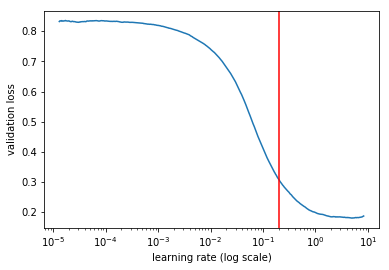

In [20]:
lr_high_last=0.2
learn.sched.plot()
plt.axvline(x=lr_high_last, color="red")

In [21]:
learn.fit(lr_high_last, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                       
    0      0.130971   0.115198   0.888187  
    1      0.122488   0.109996   0.891579                    
    2      0.121467   0.108162   0.893589                    
    3      0.120211   0.10778    0.894164                    
    4      0.117507   0.105924   0.89739                     
    5      0.11563    0.104277   0.896689                    
    6      0.11567    0.104491   0.896171                    



[array([0.10449]), 0.8961710910686075]

In [22]:
high_lastlayer = f"high_lastlayer_{img_sz_high}_{batch_sz_high}{'_all' if no_validation else ''}"; high_lastlayer

'high_lastlayer_256_64'

In [23]:
learn.unfreeze()

In [24]:
lr_high_all = np.array([lr_high_last/9,lr_high_last/3,lr_high_last])
# model has been trained with satellite data already. can decrease learning_rate for low layers

In [25]:
learn.fit(lr_high_all, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                        
    0      0.101685   0.091575   0.907768  
    1      0.09909    0.089183   0.906812                     
    2      0.090418   0.086097   0.911413                     
    3      0.09673    0.089351   0.913435                     
    4      0.091237   0.085455   0.913875                     
    5      0.088225   0.084438   0.912034                     
    6      0.08352    0.08399    0.913992                     



[array([0.08399]), 0.9139923826014567]

In [26]:
learn.fit(lr_high_all, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                        
    0      0.087035   0.083494   0.915697  
    1      0.087985   0.085379   0.911685                     
    2      0.081374   0.083258   0.913526                     
    3      0.087348   0.086295   0.913019                     
    4      0.084603   0.084471   0.916286                     
    5      0.079079   0.083223   0.914798                     
    6      0.077606   0.082803   0.913758                     



[array([0.0828]), 0.9137583085501525]

In [27]:
learn.fit(lr_high_all, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                        
    0      0.081408   0.082534   0.916716  
    1      0.082955   0.084056   0.918018                     
    2      0.077897   0.082295   0.915266                     
    3      0.083741   0.084345   0.915477                     
    4      0.078846   0.084057   0.915308                     
    5      0.078986   0.083439   0.914156                     
    6      0.073466   0.083396   0.914907                     



[array([0.0834]), 0.9149069529047663]

In [28]:
learn.fit(lr_high_all, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                        
    0      0.075211   0.083084   0.91557   
    1      0.07743    0.083788   0.916358                     
    2      0.0741     0.083502   0.914531                     
    3      0.077815   0.08687    0.913135                     
    4      0.07561    0.084828   0.912628                     
    5      0.071103   0.084368   0.912983                     
    6      0.068456   0.084565   0.914635                     



[array([0.08456]), 0.914635021130033]

# Find proper threshold

In [29]:
val_probs, val_true = learn.TTA()

In [30]:
val_prob = np.average(val_probs, axis=0)

In [31]:
th = hp.get_threshold(val_prob, val_true, stop=1);th 

0.6099999999999998

In [32]:
# Hier stirbt der Kernel!

In [33]:
hp.f2(val_true, val_prob>th)

0.9237169528784159

# Submission

In [34]:
probs_test, true_test = learn.TTA(is_test=True)

In [35]:
probs_test = np.average(probs_test, axis=0)

In [36]:
th= 0.5

In [49]:
submission = hp.create_submission(probs_test, data_high, th)

In [50]:
submission_file = f"submission_{img_sz_high}_{batch_sz_high}{'_all' if no_validation else ''}"; submission_file

'submission_256_64'

In [51]:
submission.to_csv(submission_file, index=False)

In [57]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission_256_64 -m "img_sz_low={img_sz_low}, bs_low={batch_sz_low}, img_sz_high={img_sz_high}, bs_high={batch_sz_high}"

Successfully submitted to Planet: Understanding the Amazon from Space